# 1.  영화 리뷰 가져오기

## Daum 영화 홈페이지 고려사항
- Daum 영화의 경우 리뷰 데이터 순번이 최근순이 아닌 추천순 이다
- 그리고 데이터들이 Pagenation 되어 있지 않고 평점 더보기로 되어있다

## 셀레니움으로 Daum 영화 리뷰 데이터 불러오기

In [770]:
from selenium import webdriver
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import time

In [771]:
driver = webdriver.Chrome(r"C:\Users\SH501\Downloads\chromedriver.exe")

/var/folders/zf/1b4jhl5j5xx88gqwgfd7pzv40000gn/T/ipykernel_10363/3725457065.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"C:\Users\SH501\Downloads\chromedriver.exe")


## 영화는 내 인생영화 라라랜드

In [772]:
driver.get('https://movie.daum.net/moviedb/grade?movieId=95306')

## 최근순 -> 평점 더보기
- 더보기를 50번 눌러서 최신댓글 위주로 사용

In [773]:
newest_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/ul[1]/li[3]/button/span/span')
newest_btn.click() #최신순으로 최신
times = 50
time.sleep(0.7)
for i in tqdm(range(times)):
    more_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button')
    more_btn.click()
    time.sleep(0.5)

  0%|          | 0/50 [00:00<?, ?it/s]

In [774]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

## 댓글 평점 저장
- coments: 댓글
- ratings: 평점
- 

In [775]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser') #데이터를 파싱해서 파이썬에서 가공할 수 있게
tmp_list = soup.find_all('div', class_='cmt_info') #div태그, 클래스명

ratings = []
comments = []

for tmp in tmp_list:
    comment = tmp.find('p', class_='desc_txt') #댓글 부분 추출
    rating = tmp.find('div', class_='ratings') #별점 부분 추출
    if comment: #comments(댓글) 을 기준으로 별점만 달고 댓글 없는 데이터 제외
        comments.append(comment.text) #text로 comments에 댓글 부분 저장
        ratings.append(int(rating.text)) #tex로 ratings에 별점 부분 저장 별점은 문자형이라서 int 로 형변환

# 워드 클라우드 그리기

In [776]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt

### 긍정 리뷰, 부정 리뷰 분리

In [777]:
pos_comments_tmp = []
neg_comments_tmp = []
# 평점이 1~4: 부정리뷰 9이상: 긍정리뷰 그 외는 제외
for comment, rating in zip(comments, ratings):
    if 5 < rating < 9: continue
    
    if rating >= 9:
        pos_comments_tmp.append(comment)
    else:
        neg_comments_tmp.append(comment)
    

## 긍정 리뷰
- 데이터 전처리 '\n'.join(tmp_list) 사용
- 형태소 분석기는 Okt 사용
- okt.nouns() 으로 명사만 추출
- 불용어 처리

In [778]:
okt = Okt()
all_comments = '\n'.join(comments)

In [779]:
all_comments_noun = okt.nouns(all_comments)
all_comments_count_noun = Counter(all_comments_noun) #빈도수
all_comments_count_noun.most_common(20) #빈도수 오름차순 20개만

[('영화', 540),
 ('음악', 146),
 ('사랑', 125),
 ('꿈', 97),
 ('뮤지컬', 82),
 ('마지막', 80),
 ('인생', 72),
 ('것', 71),
 ('더', 67),
 ('최고', 64),
 ('장면', 63),
 ('이', 58),
 ('현실', 57),
 ('여운', 55),
 ('정말', 52),
 ('노래', 51),
 ('그', 50),
 ('생각', 50),
 ('수', 49),
 ('감동', 43)]

In [780]:
stopword_list = ['영화', '라라', '랜드'] #불용어

for word in all_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in all_comments_count_noun:
        all_comments_count_noun.pop(stopword)

In [781]:
all_comments_count_noun.most_common(20) #불용어 처리후 다시 빈도수 오름차순 20개

[('음악', 146),
 ('사랑', 125),
 ('뮤지컬', 82),
 ('마지막', 80),
 ('인생', 72),
 ('최고', 64),
 ('장면', 63),
 ('현실', 57),
 ('여운', 55),
 ('정말', 52),
 ('노래', 51),
 ('생각', 50),
 ('감동', 43),
 ('스토리', 42),
 ('연기', 39),
 ('라이언', 38),
 ('사람', 38),
 ('결말', 36),
 ('보고', 36),
 ('남자', 36)]

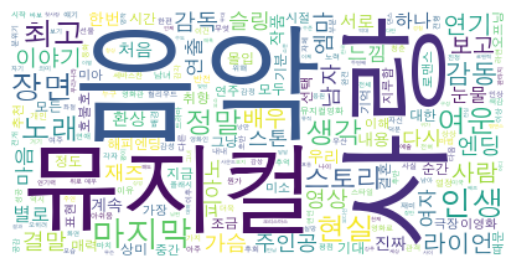

In [782]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(all_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

## 전체 리뷰 word cloud 결과 해석
- 뮤지컬 로맨스 영화다 보니 뮤지컬 음악 사랑 여운 감동 같은 단어가 제일 많았다 오른쪽 아래 엄청 작게 지루함 이라는 단어도 있는걸로 보아 지루해한 사람도 있다 이게 왜 지루하지?

- 의문인건 가장 왼쪽에 해피엔딩 도 있는데 해피엔딩이 아닌데 왜 헤피엔딩 이라는 단어가 있는지 궁금했는데 댓글을 살펴보니 "해피엔딩은 아니지만" 이런 댓글 때문이다. 단어 만으로 100퍼센트 신뢰할 수 없다. 한국어는 끝까지 들어봐야 안다 라는말이 떠올랐다

## 부정 리뷰
- 데이터 전처리 '\n'.join(tmp_list) 사용
- 형태소 분석기는 Okt 사용
- okt.nouns() 으로 명사만 추출
- 불용어 처리

In [783]:
neg_comments_tmp

['일단, 재미가 없음. 게다가 너무 뻔한 이야기.',
 '취향이 안맞으면 지루함을 끝없이 느낄수있을만한 영화. 하지만 취향이 맞는다면 정말 좋아하는 영화. 그만큼 호불호가 심하게 갈리는 영화가 아닐까.',
 '현실같은 결말을 굳이 영화에서도 보고싶지 않아',
 '보다가 중간에 나옴 영화관에서 호불호 엄청 갈리는 영화같음',
 '왜 평점이 높은지 이해가 가지않는 영화  예상외로 지루했고 주인공들의 감정선 변화가 이해되지 않았다 마지막에 헤어지는 이유도....',
 '뮤지컬 영화 좋아하는데 재즈를 별로 안 좋아해서 그런지 음악도 그냥 그랬고 내용은 안 들어오고 보면서 딴 짓 하게 됨.\n6~70년대 올드한 미국영화 느낌.',
 '호불호가 갈리는영화..\n이런 취향이 아니라면 상영내내 지옥... 진자 지루하다..',
 '음악은 좋다. 나머진 그닥...',
 '웰메이드',
 '아니 남자보곤 멀리 오래 가지 못 하게 하고선 자기는 결혼해서 애까지 만들어오네??',
 '나만 재미없는가..내가 이상한건지.   ',
 '영상은 매우 아름다우나 나는 졸렸다.\n영화 감각이 없나보다.',
 '흔하디 흔한 아픔을 가진 남녀간의 로맨스...통속적 뮤지컬 영화에 지나지 않음. 좋은음악 듣자고 2시간을 낭비하는 것은 미친짓...지나친 인내심을 강요하는 영화...',
 '이기심의 끝을 달리는 최악의 영화',
 '솔직히 난 별로 평이 좋아 블루레이 구매해서 보다가 잠들어버림 두번째시도 또 잠들어버림 ',
 '하도 평이 좋길래 함봤는데,,영화가 참 심심하구나',
 '솔직히 전 재미없서요...',
 '기대가 크면 실망도 큰 법이라던데..',
 '쎄시봉 재즈 판.\n위플레시 감독도 어쩔 수 없구나.',
 '아. 진심 끝까지 본 나를 미워하게 되는 영화.\n역겹다',
 '보다가 껐다',
 '코요테 어글리가 더 신나고,어거스트러쉬가 더 감동이고 비긴어게인이 더 재밌고, 파리넬리가 더 멋지다\n난 전혀 재미를 느끼지 못했고 감동을 받지 못했다 ',
 '글쎄 난 잘 모르겠네.',
 '쓰레기   시간

In [784]:
okt = Okt()
neg_comments = '\n'.join(neg_comments_tmp)

In [785]:
neg_comments_noun = okt.nouns(neg_comments)
neg_comments_count_noun = Counter(neg_comments_noun) #빈도수
neg_comments_count_noun.most_common(20) #빈도수 오름차순 20개

[('영화', 52),
 ('음악', 17),
 ('뮤지컬', 12),
 ('스토리', 12),
 ('별로', 10),
 ('지루함', 9),
 ('평점', 9),
 ('느낌', 9),
 ('더', 9),
 ('진짜', 9),
 ('이', 9),
 ('감동', 8),
 ('노래', 8),
 ('취향', 7),
 ('안', 7),
 ('보고', 7),
 ('이해', 6),
 ('그냥', 6),
 ('끝', 6),
 ('그', 6)]

In [786]:
stopword_list = ['영화'] #불용어

for word in neg_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in neg_comments_count_noun:
        neg_comments_count_noun.pop(stopword)

In [787]:
neg_comments_count_noun.most_common(20) #불용어 처리 후 빈도수 오름차순 20개

[('음악', 17),
 ('뮤지컬', 12),
 ('스토리', 12),
 ('별로', 10),
 ('지루함', 9),
 ('평점', 9),
 ('느낌', 9),
 ('진짜', 9),
 ('감동', 8),
 ('노래', 8),
 ('취향', 7),
 ('보고', 7),
 ('이해', 6),
 ('그냥', 6),
 ('생각', 6),
 ('호불호', 5),
 ('주인공', 5),
 ('재즈', 5),
 ('내용', 5),
 ('영상', 5)]

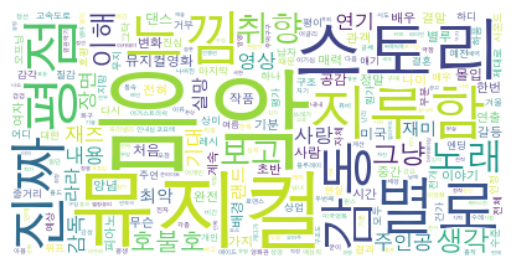

In [788]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(neg_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

## 부정 리뷰 word cloud 결과 해석
- 음악, 스토리, 뮤지컬 같이 영화의 특징을 보여주는 단어들이 주를 이루었다
- 전체 리뷰 word cloud 에 없던 별로, 지루함, 최악, 실망 등등 부정적인 단어들이 생겼다 하지만 4개 단어 외에는 부정 리뷰라고 보기 힘든 단어들이 대부분이다

## 긍정 리뷰
- 데이터 전처리 '\n'.join(tmp_list) 사용
- 형태소 분석기는 Okt 사용
- okt.nouns() 으로 명사만 추출
- 불용어 처리

In [789]:
pos_comments_tmp

['아름다운 러브스토리,,결국엔 서로 다른길로 가게 된다는게 오히려 더 현실감 있다 퐌타스틱함이 더해지고 뮤지컬이라지만 전혀 뮤지컬 답지 않아 진부하지만 더 실감나는영화 두 배우의 연기력에 라이언 정말 피아노 실력 일까 대단함',
 '뮤지컬을 좋아하지 않는 관객들한테도 사랑 받을만한 영화....사랑은 비를 타고, 쉘부르의 우산, 카사블랑카, 이유없는 반항 같은 고전명작을 좋아하는 관객들 한테는 백만점 짜리 영화~~',
 '꿈을 향해 달리던 그시절이 진정 꿈속이었음을!\n마지막 5분은 아쉬움과...',
 '굿',
 'Here’s to the fools who dream. 꿈꾸는 바보들을 위한 작은 위로.',
 '놀고있네~ 예쁘게',
 '미아 와 세바스찬의  결혼생활 나온 장면을 기억하고 싶어요 ㅎ   두 주인공 은 해피엔딩~~~',
 '고마워. 이런 영화를 볼 수 있어서.',
 '좋아하게돼서 좋아했는데 좋다\n한번도 실망시킨적없는 지금도 앞으로도 볼 영화\n누구처럼',
 '마지막 10분.. 너무 마음 아프다. 마치 영화 나비효과를 보는듯한. 그래도 라이언고슬링의 고개 끄덕이면서 짓는 미소덕분에 그 아픔이 조금이나마 덜어진듯. \n뮤지컬 영화를 참 좋아라하는데 이 영화 역시 아주 재밌게 잘봤다. 보는 내내 얼굴에서 미소가 떠나지 않았음.',
 '낼모레 40먹은 아저씨에요.  마지막 장면에서 울었습니다. 영원히 사랑한다며!!!!',
 '가슴에 남아 있는  사랑의 추억...어땠을까.....',
 '연기도 좋고 노래도 좋고 영상도 좋고, 기분이 좋아지는 뮤지컬 영화',
 '최고였다',
 '.',
 '뮤지컬 영화 좋아하는 일인으로\n재밌게봄ㅎ',
 '이런 영화를 보면서 졸리다고 하면 그냥 삼류영화를 보는 게 낫다',
 '오늘 사운드 트랙만 하루종일 듣고, 다시 한번 또 봤다만.... 가까워 지고 둘이 사랑을 하는데 뭔가 몰입이 안된다. 불안불안 하면서 언젠가 안좋은 결말을 맺을 느낌이랄까? 이건 결말을 알아서 그런걸까?;; 사실 내용은 딱히 볼게 없다. 음악하고, 미술만

In [790]:
okt = Okt()
pos_comments = '\n'.join(pos_comments_tmp)

In [791]:
pos_comments_noun = okt.nouns(pos_comments)
pos_comments_count_noun = Counter(pos_comments_noun) #빈도수
pos_comments_count_noun.most_common(20) #빈도수 오름차순 20개

[('영화', 392),
 ('음악', 93),
 ('사랑', 88),
 ('꿈', 65),
 ('인생', 64),
 ('최고', 59),
 ('마지막', 56),
 ('것', 48),
 ('장면', 47),
 ('뮤지컬', 44),
 ('정말', 44),
 ('여운', 40),
 ('더', 38),
 ('이', 36),
 ('그', 34),
 ('현실', 32),
 ('노래', 31),
 ('수', 30),
 ('라이언', 28),
 ('가슴', 28)]

In [792]:
stopword_list = ['영화'] #불용어

for word in pos_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in pos_comments_count_noun:
        pos_comments_count_noun.pop(stopword)

In [793]:
pos_comments_count_noun.most_common(20) #불용어 처리하고 빈도수 오름차순 20개

[('음악', 93),
 ('사랑', 88),
 ('인생', 64),
 ('최고', 59),
 ('마지막', 56),
 ('장면', 47),
 ('뮤지컬', 44),
 ('정말', 44),
 ('여운', 40),
 ('현실', 32),
 ('노래', 31),
 ('라이언', 28),
 ('가슴', 28),
 ('보고', 28),
 ('연기', 27),
 ('생각', 27),
 ('이야기', 27),
 ('엔딩', 26),
 ('감동', 26),
 ('영상', 25)]

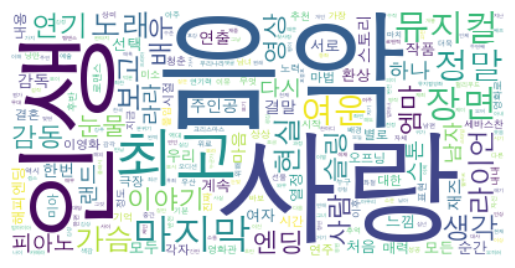

In [794]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(pos_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

## 긍정 리뷰 word cloud 결과 해석
- 음악, 스토리, 뮤지컬, 사랑 같이 영화의 특징을 보여주는 단어들이 주를 이루었다


## 긍정리뷰 & 부정리뷰 비교
- 둘다 공통적으로 로맨스 뮤지컬 영화의 특징을 드러내는 "뮤지컬, 음악, 영화, 사랑" 같은 단어가 주를 이룬다
- 명작 답게 부정 리뷰의 전처리된 단어수가 현저히 적다
- 명작 답게 긍정 리뷰와 전체 리뷰 word cloud 의 큰 차이를 못 느끼겠다


## 분류기 학습 시키기

In [795]:
from nltk.tokenize import word_tokenize
import nltk
from konlpy.tag import Okt
okt = Okt()

def load_data(comments):
    train = []
    count = 0
    for comment in comments:
        contents, label = comment[0], comment[1]
        if count == 2001: break
        count += 1
        if label == '1': label = 'pos'
        else: label = 'neg'
        train.append((contents, label))
    return train

def load_data_balance(comments):
    train = []
    neg_count = 0
    pos_count = 0
    for comment in comments:
        contents, label = comment[0], comment[1]
        if label == '1' and pos_count < 200:
            pos_count += 1
            label = 'pos'
        elif label == '0' and neg_count < 200:
            neg_count += 1
            label = 'neg'
        train.append((contents, label))
    return train

def pos_tokenize(raw_sent):
    pos_sent = []
    
    sent = okt.pos(raw_sent, norm=True, stem=True)
    for tup in sent:
        word, tag = tup
        word_tag = word + '/' + tag
        pos_sent.append(word_tag)
       
    return ' '.join(pos_sent) 

def make_word_dict(train, use_morph=False):
    all_words = set()
    for tup in train:
        sent, label = tup
        if use_morph: sent = pos_tokenize(sent)
        word_list = word_tokenize(sent)
        for word in word_list:
            all_words.add(word)
    return all_words

def make_train_feats(train, all_words, use_morph=False):
    train_features = []
    for tup in train:
        sent, label = tup # sent:'I like you' label: 'pos'
        if use_morph: sent = pos_tokenize(sent)
        word_list = word_tokenize(sent) # ['I', like, you]
        tmp = {set_word: set_word in word_list for set_word in all_words}
        train_feature = (tmp, label)
        train_features.append(train_feature)
    return train_features

## load_data 에 사용할 수 있게 label 이 있는 데이터로 변환

In [796]:
label_comments = []

for comment, rating in zip(comments, ratings):
    if 5 < rating < 9: continue
    
    if rating >= 9:
        label_comments.append((comment, '1'))
    else:
        label_comments.append((comment, '0'))


In [797]:
train = load_data(label_comments)
use_morph = True
all_words = make_word_dict(train, use_morph)
train_features = make_train_feats(train, all_words, use_morph)

In [798]:
classifier = nltk.NaiveBayesClassifier.train(train_features)
classifier.show_most_informative_features()

Most Informative Features
          재미없다/Adjective = True              neg : pos    =     21.6 : 1.0
          기대하다/Adjective = True              neg : pos    =     15.9 : 1.0
            높다/Adjective = True              neg : pos    =     15.9 : 1.0
                 맞다/Verb = True              neg : pos    =     13.0 : 1.0
          솔직하다/Adjective = True              neg : pos    =     13.0 : 1.0
                 실망/Noun = True              neg : pos    =     13.0 : 1.0
                 취향/Noun = True              neg : pos    =     11.3 : 1.0
                  ...... = True              neg : pos    =     10.1 : 1.0
                 갈등/Noun = True              neg : pos    =     10.1 : 1.0
                  감/Noun = True              neg : pos    =     10.1 : 1.0


In [799]:
test_sent = '재미없다'

if use_morph: test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}

classifier.classify(test_feature)

'pos'

### 왜 안될까 처음에는 코드가 잘못된줄 알고 코드를 하나하나 다 고쳐봤다 중간중간 이때까지 잘 되고 있는지 출력해주는 코드를 넣어봤다 단어별 확률 계산까지 잘 된거같은데 ppt 를 처음부터 다시 따라가보니 수업시간에 학습시킨 데이터는 pos : neg 비율이 거의 1:1 인것을 발견했다

### 아까 부정적인 댓글의 워드 클라우드는 워낙 명작이다 보니 워드 클라우드에 부정적인 단어가 4개밖에 없었다 그래서 부정 댓글과 긍정 댓글 length 를 봤다

In [800]:
len(pos_comments)

27483

In [801]:
len(neg_comments)

6258

### 보자마자 이런 생각이 들었다 아 부정적인 데이터가 별로 없어서 부정적인 학습이 부족했고 어떤 부정적인 말에도 pos 를 대답하는 긍정적인 기계가 되었구나

### 내생각이 맞는지 테스트하기 위해 호불호가 갈리는 평점이 극과 극인 영화를 찾아봤다 솔찍히 불호가 더 많지만 사람들은 재미있는 영화는 만점 평점을 주고 재미없는 영화는 그냥 평점을 안다는 성향을 생각해서 월드스타 비 주연 자전차왕 엄복동으로 기계 학습을 시켜 보았다

In [802]:
driver.get('https://movie.daum.net/moviedb/grade?movieId=108882')

In [803]:
newest_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/ul[1]/li[3]/button/span/span')
newest_btn.click()
times = 50
time.sleep(0.7)
for i in tqdm(range(times)):
    more_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button')
    more_btn.click()
    time.sleep(0.5)

  0%|          | 0/50 [00:00<?, ?it/s]

In [804]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser') #데이터를 파싱해서 파이썬에서 가공할 수 있게
tmp_list = soup.find_all('div', class_='cmt_info') #div태그, 클래스명

ratings = []
comments = []

for tmp in tmp_list:
    comment = tmp.find('p', class_='desc_txt') #댓글 부분 추출
    rating = tmp.find('div', class_='ratings') #별점 부분 추출
    if comment: #comments(댓글) 을 기준으로 별점만 달고 댓글 없는 데이터 제외
        comments.append(comment.text) #text로 comments에 댓글 부분 저장
        ratings.append(int(rating.text)) #tex로 ratings에 별점 부분 저장 별점은 문자형이라서 int 로 형변환

In [805]:
pos_comments_tmp = []
neg_comments_tmp = []
# 평점이 1~4: 부정리뷰 9이상: 긍정리뷰 그 외는 제외
for comment, rating in zip(comments, ratings):
    if 5 < rating < 9: continue
    
    if rating >= 9:
        pos_comments_tmp.append(comment)
    else:
        neg_comments_tmp.append(comment)

In [806]:
okt = Okt()
all_comments = '\n'.join(comments)
all_comments_noun = okt.nouns(all_comments)
all_comments_count_noun = Counter(all_comments_noun) #빈도수
all_comments_count_noun.most_common(20) #빈도수 오름차순 20개만

[('영화', 514),
 ('감동', 133),
 ('비', 124),
 ('평점', 110),
 ('연기', 106),
 ('엄복동', 98),
 ('점', 90),
 ('생각', 89),
 ('배우', 80),
 ('왜', 75),
 ('이', 72),
 ('사람', 71),
 ('것', 67),
 ('돈', 57),
 ('보고', 55),
 ('자전거', 51),
 ('정말', 49),
 ('정지훈', 46),
 ('재미', 46),
 ('진짜', 45)]

In [807]:
stopword_list = ['영화', '엄복동', '비'] #불용어

for word in all_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in all_comments_count_noun:
        all_comments_count_noun.pop(stopword)

In [808]:
all_comments_count_noun.most_common(20) #불용어 처리후 다시 빈도수 오름차순 20개

[('감동', 133),
 ('평점', 110),
 ('연기', 106),
 ('생각', 89),
 ('배우', 80),
 ('사람', 71),
 ('보고', 55),
 ('자전거', 51),
 ('정말', 49),
 ('정지훈', 46),
 ('재미', 46),
 ('진짜', 45),
 ('스토리', 42),
 ('알바', 41),
 ('감독', 40),
 ('정도', 40),
 ('자전차', 38),
 ('가족', 34),
 ('눈물', 31),
 ('캐스팅', 30)]

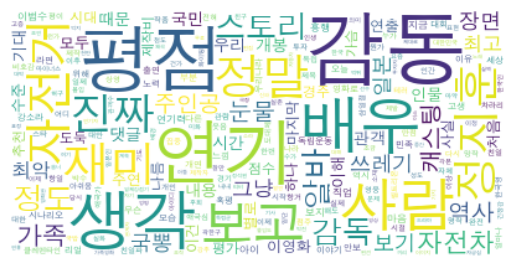

In [809]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(all_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

In [810]:
okt = Okt()
neg_comments = '\n'.join(neg_comments_tmp)
neg_comments_noun = okt.nouns(neg_comments)
neg_comments_count_noun = Counter(neg_comments_noun) #빈도수
neg_comments_count_noun.most_common(20) #빈도수 오름차순 20개

[('영화', 245),
 ('비', 84),
 ('점', 60),
 ('이', 51),
 ('돈', 49),
 ('연기', 47),
 ('배우', 45),
 ('엄복동', 43),
 ('것', 39),
 ('자전거', 36),
 ('사람', 35),
 ('감독', 34),
 ('생각', 34),
 ('평점', 34),
 ('알바', 33),
 ('진짜', 27),
 ('뭐', 26),
 ('캐스팅', 26),
 ('왜', 25),
 ('정지훈', 25)]

In [811]:
stopword_list = ['영화', '엄복동'] #불용어

for word in neg_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in neg_comments_count_noun:
        neg_comments_count_noun.pop(stopword)

In [812]:
neg_comments_count_noun.most_common(20) #불용어 처리 후 빈도수 오름차순 20개

[('연기', 47),
 ('배우', 45),
 ('자전거', 36),
 ('사람', 35),
 ('감독', 34),
 ('생각', 34),
 ('평점', 34),
 ('알바', 33),
 ('진짜', 27),
 ('캐스팅', 26),
 ('정지훈', 25),
 ('주인공', 23),
 ('최악', 23),
 ('쓰레기', 23),
 ('국뽕', 21),
 ('주연', 20),
 ('스토리', 20),
 ('이건', 18),
 ('자전차', 18),
 ('재미', 16)]

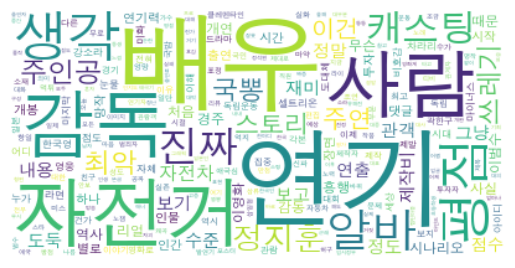

In [813]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(neg_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

In [814]:
okt = Okt()
pos_comments = '\n'.join(pos_comments_tmp)
pos_comments_noun = okt.nouns(pos_comments)
pos_comments_count_noun = Counter(pos_comments_noun) #빈도수
pos_comments_count_noun.most_common(20) #빈도수 오름차순 20개

[('영화', 208),
 ('감동', 117),
 ('평점', 64),
 ('엄복동', 47),
 ('연기', 41),
 ('왜', 39),
 ('생각', 35),
 ('보고', 34),
 ('비', 32),
 ('정말', 31),
 ('배우', 28),
 ('가족', 26),
 ('사람', 25),
 ('재미', 25),
 ('눈물', 23),
 ('볼', 22),
 ('꼭', 20),
 ('점', 19),
 ('나', 19),
 ('최고', 19)]

In [815]:
stopword_list = ['영화', '엄복동'] #불용어

for word in pos_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in pos_comments_count_noun:
        pos_comments_count_noun.pop(stopword)

In [816]:
pos_comments_count_noun.most_common(20) #불용어 처리하고 빈도수 오름차순 20개

[('감동', 117),
 ('평점', 64),
 ('연기', 41),
 ('생각', 35),
 ('보고', 34),
 ('정말', 31),
 ('배우', 28),
 ('가족', 26),
 ('사람', 25),
 ('재미', 25),
 ('눈물', 23),
 ('최고', 19),
 ('우리', 19),
 ('진짜', 18),
 ('기대', 18),
 ('정지훈', 17),
 ('가슴', 17),
 ('국민', 16),
 ('역사', 15),
 ('자전차', 14)]

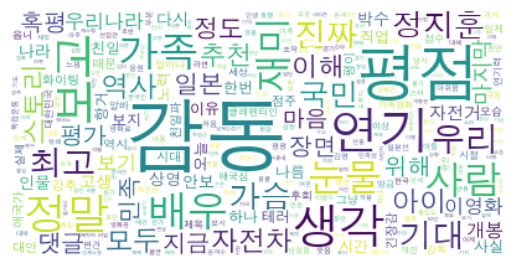

In [817]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(pos_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

In [818]:
label_comments = []

for comment, rating in zip(comments, ratings):
    if 5 < rating < 9: continue
    
    if rating >= 9:
        label_comments.append((comment, '1'))
    else:
        label_comments.append((comment, '0'))


In [819]:
train = load_data(label_comments)
use_morph = True
all_words = make_word_dict(train, use_morph)
train_features = make_train_feats(train, all_words, use_morph)

In [820]:
classifier = nltk.NaiveBayesClassifier.train(train_features)
classifier.show_most_informative_features()

Most Informative Features
          재미있다/Adjective = True              pos : neg    =     35.2 : 1.0
                 기대/Noun = True              pos : neg    =     19.9 : 1.0
                 우리/Noun = True              pos : neg    =     18.8 : 1.0
               함께/Adverb = True              pos : neg    =     17.8 : 1.0
                 가족/Noun = True              pos : neg    =     17.1 : 1.0
           괜찮다/Adjective = True              pos : neg    =     15.8 : 1.0
                 감동/Noun = True              pos : neg    =     15.8 : 1.0
                 추천/Noun = True              pos : neg    =     14.5 : 1.0
            낮다/Adjective = True              pos : neg    =     13.2 : 1.0
           재밌다/Adjective = True              pos : neg    =     12.6 : 1.0


In [821]:
test_sent = '생각보다 괜찮은데? 나는 엄청 재밌게 봤음'

if use_morph: test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}

classifier.classify(test_feature)

'pos'

In [822]:
test_sent = '이게 뭐임 비 주연이라 기대했는데'

if use_morph: test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}

classifier.classify(test_feature)

'neg'

In [823]:
len(pos_comments)

20319

In [824]:
len(neg_comments)

26935

### 어느정도 긍정 부정 비율이 맞으니까 제대로 학습이 되었다

### 옛날에 초등학교때 슈퍼주니어 광팬인 친척누나가 슈퍼주니어가 나오는 영화인 꽃미남 연쇄 테러사건 이라는 영화를 강제로 보게했다 그게 너무 고문이였기 때문에 그영화는 필히 평점에 부정적인 댓글만 있을거라 생각했는데 긍정적인 댓글밖에 없었다 그만큼 부정적인 댓글만 있는 영화를 찾기 힘들었는데

### 오랜 구글링을 통해 사상 최악의 영화인 다세포 소녀라는 영화를 찾을 수 있었다 댓글을 보면 내가 상처받을 정도로 처참하다

In [825]:
driver.get('https://movie.daum.net/moviedb/grade?movieId=41208')

In [826]:
newest_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/ul[1]/li[3]/button/span/span')
newest_btn.click()
times = 40
time.sleep(0.7)
for i in tqdm(range(times)):
    more_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button')
    more_btn.click()
    time.sleep(0.5)

  0%|          | 0/40 [00:00<?, ?it/s]

In [827]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser') #데이터를 파싱해서 파이썬에서 가공할 수 있게
tmp_list = soup.find_all('div', class_='cmt_info') #div태그, 클래스명

ratings = []
comments = []

for tmp in tmp_list:
    comment = tmp.find('p', class_='desc_txt') #댓글 부분 추출
    rating = tmp.find('div', class_='ratings') #별점 부분 추출
    if comment: #comments(댓글) 을 기준으로 별점만 달고 댓글 없는 데이터 제외
        comments.append(comment.text) #text로 comments에 댓글 부분 저장
        ratings.append(int(rating.text)) #tex로 ratings에 별점 부분 저장 별점은 문자형이라서 int 로 형변환

In [828]:
pos_comments_tmp = []
neg_comments_tmp = []
# 평점이 1~4: 부정리뷰 9이상: 긍정리뷰 그 외는 제외
for comment, rating in zip(comments, ratings):
    if 5 < rating < 9: continue
    
    if rating >= 9:
        pos_comments_tmp.append(comment)
    else:
        neg_comments_tmp.append(comment)
    

In [829]:
okt = Okt()
all_comments = '\n'.join(comments)
all_comments_noun = okt.nouns(all_comments)
all_comments_count_noun = Counter(all_comments_noun) #빈도수
all_comments_count_noun.most_common(20) #빈도수 오름차순 20개만

[('영화', 662),
 ('돈', 192),
 ('정말', 159),
 ('점', 140),
 ('진짜', 91),
 ('이', 87),
 ('사람', 86),
 ('최악', 80),
 ('쓰레기', 79),
 ('평점', 72),
 ('내', 68),
 ('생각', 63),
 ('처음', 61),
 ('완전', 59),
 ('보고', 57),
 ('왜', 57),
 ('거', 56),
 ('중간', 53),
 ('내용', 53),
 ('감독', 52)]

In [830]:
stopword_list = ['영화', '김옥빈', '이영화'] #불용어

for word in all_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in all_comments_count_noun:
        all_comments_count_noun.pop(stopword)

In [831]:
all_comments_count_noun.most_common(20) #불용어 처리후 다시 빈도수 오름차순 20개

[('정말', 159),
 ('진짜', 91),
 ('사람', 86),
 ('최악', 80),
 ('쓰레기', 79),
 ('평점', 72),
 ('생각', 63),
 ('처음', 61),
 ('완전', 59),
 ('보고', 57),
 ('중간', 53),
 ('내용', 53),
 ('감독', 52),
 ('점수', 38),
 ('친구', 37),
 ('시간', 31),
 ('재미', 30),
 ('그냥', 29),
 ('스토리', 29),
 ('전문가', 27)]

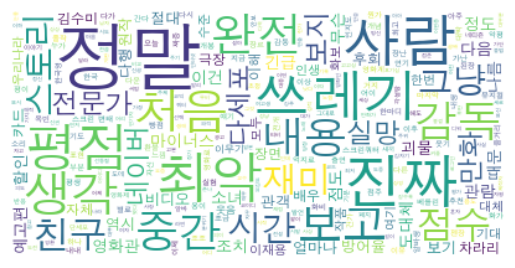

In [832]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(all_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

### 전체 리뷰인데 워드 클라우드로 보니 너무 무섭다 선플 공익광고 캠페인에서 본거 같은 느낌이다

In [833]:
okt = Okt()
neg_comments = '\n'.join(neg_comments_tmp)
neg_comments_noun = okt.nouns(neg_comments)
neg_comments_count_noun = Counter(neg_comments_noun) #빈도수
neg_comments_count_noun.most_common(20) #빈도수 오름차순 20개

[('영화', 591),
 ('돈', 187),
 ('정말', 142),
 ('점', 121),
 ('진짜', 86),
 ('이', 85),
 ('쓰레기', 77),
 ('최악', 73),
 ('사람', 73),
 ('내', 63),
 ('평점', 57),
 ('완전', 57),
 ('처음', 55),
 ('생각', 52),
 ('내용', 50),
 ('거', 49),
 ('감독', 48),
 ('말', 48),
 ('보고', 48),
 ('왜', 45)]

In [834]:
stopword_list = ['영화', '감독', '네이버'] #불용어

for word in neg_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in neg_comments_count_noun:
        neg_comments_count_noun.pop(stopword)
neg_comments_count_noun.most_common(20) #불용어 처리 후 빈도수 오름차순 20개

[('정말', 142),
 ('진짜', 86),
 ('쓰레기', 77),
 ('최악', 73),
 ('사람', 73),
 ('평점', 57),
 ('완전', 57),
 ('처음', 55),
 ('생각', 52),
 ('내용', 50),
 ('보고', 48),
 ('중간', 42),
 ('점수', 34),
 ('친구', 34),
 ('시간', 29),
 ('이영화', 28),
 ('재미', 27),
 ('보지', 26),
 ('실망', 26),
 ('전문가', 25)]

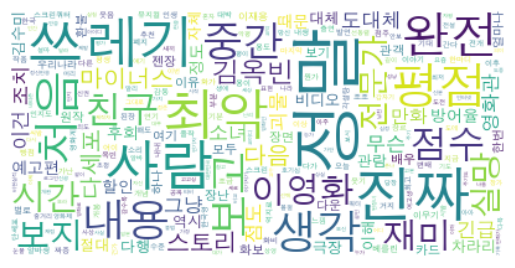

In [835]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(neg_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

### 보는 나까지 정신이 피폐해지는 느낌이다

In [836]:
okt = Okt()
pos_comments = '\n'.join(pos_comments_tmp)
pos_comments_noun = okt.nouns(pos_comments)
pos_comments_count_noun = Counter(pos_comments_noun) #빈도수
pos_comments_count_noun.most_common(20) #빈도수 오름차순 20개

[('영화', 54),
 ('점', 16),
 ('정말', 14),
 ('평점', 12),
 ('난', 11),
 ('나', 8),
 ('꼭', 8),
 ('보고', 8),
 ('사람', 8),
 ('왜', 8),
 ('좀', 6),
 ('관람', 6),
 ('기대', 6),
 ('나름', 5),
 ('볼', 5),
 ('제', 5),
 ('것', 5),
 ('전', 5),
 ('정도', 4),
 ('거', 4)]

In [837]:
stopword_list = ['영화', '이영화'] #불용어

for word in pos_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in pos_comments_count_noun:
        pos_comments_count_noun.pop(stopword)

In [838]:
pos_comments_count_noun.most_common(20) #불용어 처리하고 빈도수 오름차순 20개

[('정말', 14),
 ('평점', 12),
 ('보고', 8),
 ('사람', 8),
 ('관람', 6),
 ('기대', 6),
 ('나름', 5),
 ('정도', 4),
 ('그냥', 4),
 ('인생', 4),
 ('김옥빈', 4),
 ('만화', 4),
 ('스토리', 4),
 ('소녀', 4),
 ('작품', 4),
 ('점수', 4),
 ('관객', 4),
 ('생각', 3),
 ('장면', 3),
 ('처음', 3)]

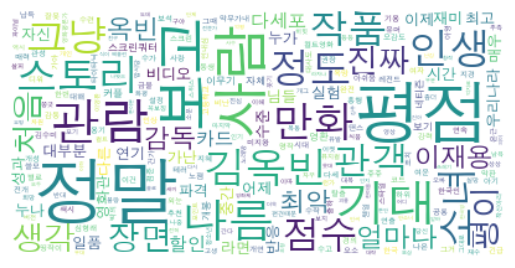

In [839]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(pos_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

### 정확하게 라라랜드의 부정 댓글의 반대를 보여주고 있다
- 명작 라라랜드: 부정 댓글 word cloud 는 4개의 부정적인 단어 빼고 전부 부정적이라고 보기 힘든 단어 뿐.
- 망작 다세포 소녀: 긍정 댓글 word cloud 는 나름, 기대 외에는 전부 긍정적이라고 보기 힘든 단어 뿐.

In [840]:
label_comments = []

for comment, rating in zip(comments, ratings):
    if 5 < rating < 9: continue
    
    if rating >= 9:
        label_comments.append((comment, '1'))
    else:
        label_comments.append((comment, '0'))

In [841]:
train = load_data(label_comments)
use_morph = True
all_words = make_word_dict(train, use_morph)
train_features = make_train_feats(train, all_words, use_morph)

In [842]:
classifier = nltk.NaiveBayesClassifier.train(train_features)
classifier.show_most_informative_features()

Most Informative Features
           괜찮다/Adjective = True              pos : neg    =     41.2 : 1.0
                  표/Noun = True              pos : neg    =     22.2 : 1.0
                       ] = True              pos : neg    =     15.8 : 1.0
        ㅇ/KoreanParticle = True              pos : neg    =     15.8 : 1.0
                놀라다/Verb = True              pos : neg    =     15.8 : 1.0
                대부분/Noun = True              pos : neg    =     15.8 : 1.0
              만들어지다/Verb = True              pos : neg    =     15.8 : 1.0
              세/Modifier = True              pos : neg    =     15.8 : 1.0
                 영환/Noun = True              pos : neg    =     15.8 : 1.0
          참신하다/Adjective = True              pos : neg    =     15.8 : 1.0


In [843]:
len(pos_comments)

4500

In [844]:
len(neg_comments)

40686

### 예상했다싶이 부정댓글이 압도적으로 많다

In [845]:
test_sent = '재미있다'

if use_morph: test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}

classifier.classify(test_feature)

'neg'

In [846]:
test_sent = '최고 최고 짱짱짱!'

if use_morph: test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}

classifier.classify(test_feature)

'neg'

### 연역적 추론이 정확했다 어떤 긍적적인 말을 해도 neg 를 말하는 부정적인 기계가 되어 버렸다


## 긍정적인 댓글과 부정적인 댓글의 비율이 1:1 에 가까울 수록 학습이 잘된다

## 나만의 결과물 만들기

### 영화는 자전차왕 엄복동으로 정했다
- 문득 자전차왕 엄복동 전체 리뷰에 대한 워드 클라우드를 보면 전체적으로 좋은 단어들이 주를 이룬다 하지만 자전차왕 엄복동은 평점4.6에 코로나 아닐때 누적관객 17만 명인 대표적인 흥행 실패작이다
- 하지만 추천수 순으로 댓글을보면 0점 댓글만 보인다 그런데 자전차왕 엄복동의 전체 리뷰 word cloud 에는 긍정적인 단어들이 주를 이룬다
- word cloud는 데이터를 분석하여 중요도나 인기도 등을 고려하여 시각적으로 보여주는 것이다
- 그리고 다음 영화 리뷰에는 소위 따봉 이라 불리는 댓글을 추천할 수 있는 기능이 있다 많은 사람들이 그 리뷰에 대해서 공감을 해야 추천 수가 많다
- 따봉이 있는 리뷰는 리뷰중에서 신뢰도가 높은 알짜배기 데이터이다
- 따봉이 있는 인기있는 알짜배기 데이터만 워드클라우드에 그리면 더 질좋은 시각화를 할 수 있다 생각했다

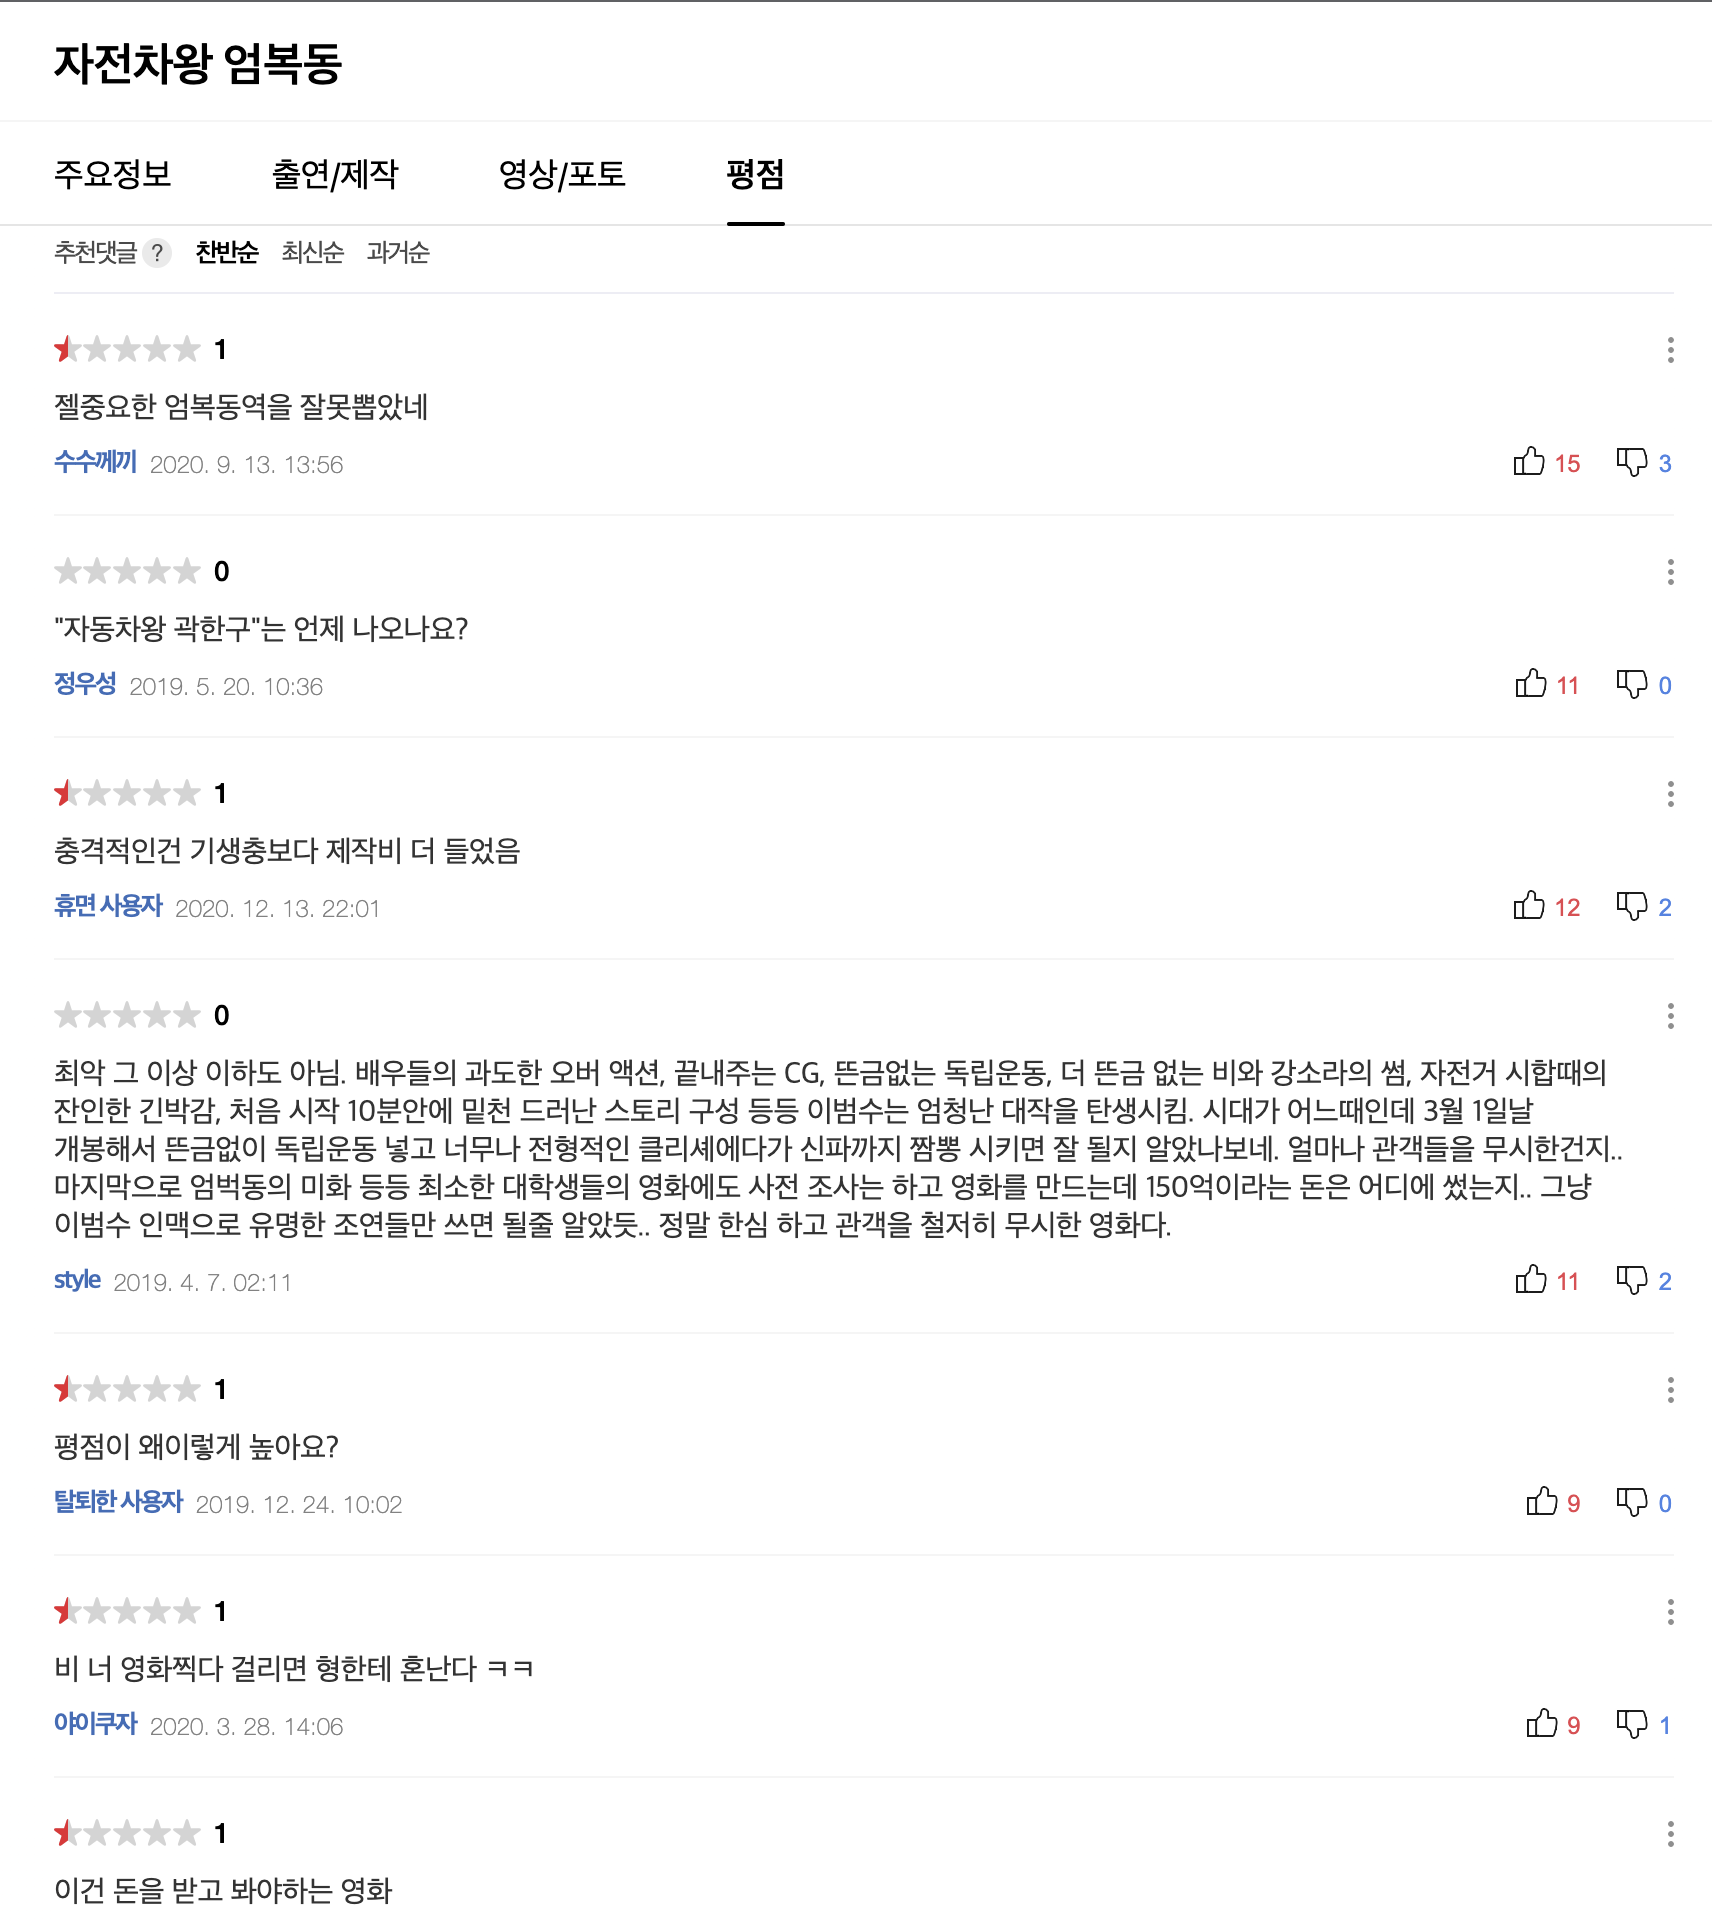

## 이렇게 혹평이 추천을 많이 받는 영화가 이런 좋은 단어가 주를 이루는 word cloud 가 나온다 이런 영화에 대한 데이터 시각화가 이렇게 이루어 진다면 과연 좋은 word cloud 라 할 수 있을까?
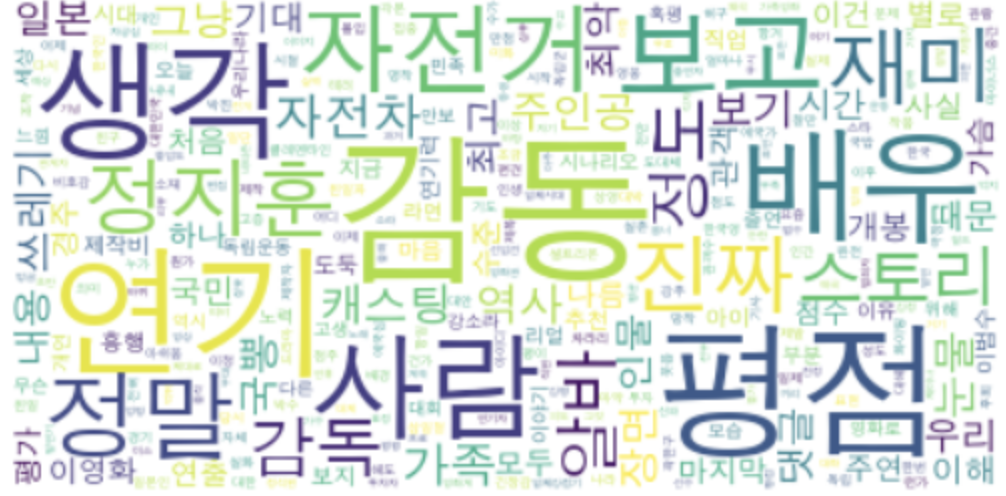

In [847]:
driver.get('https://movie.daum.net/moviedb/grade?movieId=108882')

In [848]:
times = 2 #보통 따봉이 눌린 리뷰는 많아야 70개 이하기 때문에 더보기를 두번만 눌렀다
time.sleep(0.7)
for i in tqdm(range(times)):
    more_btn = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button')
    more_btn.click()
    time.sleep(0.5)

  0%|          | 0/2 [00:00<?, ?it/s]

In [849]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser') #데이터를 파싱해서 파이썬에서 가공할 수 있게
tmp_list = soup.find_all('div', class_='cmt_info') #div태그, 클래스명

recommends = []
comments = []

for tmp in tmp_list:
    comment = tmp.find('p', class_='desc_txt') #댓글 부분 추출
    recommend = tmp.find('span', class_='num_txt') #따봉 부분 추출
    if comment == None: # 코멘트없는 리뷰 제외
        continue;
    if int(recommend.text) > 0: #따봉수 1개 이상인 데이터만 저장
        comments.append(comment.text)
    else:
        break;
        
        

In [850]:
comments

['젤중요한 엄복동역을 잘못뽑았네',
 '"자동차왕 곽한구"는 언제 나오나요?',
 '충격적인건 기생충보다 제작비 더 들었음',
 '최악 그 이상 이하도 아님. 배우들의 과도한 오버 액션, 끝내주는 CG, 뜬금없는 독립운동, 더 뜬금 없는 비와 강소라의 썸, 자전거 시합때의 잔인한 긴박감, 처음 시작 10분안에 밑천 드러난 스토리 구성 등등 이범수는 엄청난 대작을 탄생시킴. 시대가 어느때인데 3월 1일날 개봉해서 뜬금없이 독립운동 넣고 너무나 전형적인 클리셰에다가 신파까지 짬뽕 시키면 잘 될지 알았나보네. 얼마나 관객들을 무시한건지.. 마지막으로 엄벅동의 미화 등등 최소한 대학생들의 영화에도 사전 조사는 하고 영화를 만드는데 150억이라는 돈은 어디에 썼는지.. 그냥 이범수 인맥으로 유명한 조연들만 쓰면 될줄 알았듯.. 정말 한심 하고 관객을 철저히 무시한 영화다.',
 '평점이 왜이렇게 높아요? ',
 '비 너 영화찍다 걸리면 형한테 혼난다 ㅋㅋ',
 '이건 돈을 받고 봐야하는 영화',
 '연출, 연기, 시나리오, 음향... 와... 거짓말 안하고 80년대 영화 보는 줄 알았다. 어쩜 저렇게 촌스럽고 어설프냐... 특히 배우들이 연기 곧잘하는 배우들 많이 나오는데, 죄다 저런거 보면 감독이 참 대단한거 같다. 저 배우들 가지고 영화를 이렇게 찍다니... 내용은 그렇게 나쁘진 않으나, 영화 망하는 데는 다 이유가 있다는걸 여과없이 지대로 보여준 영화. ',
 '연기를 발가락으로하네 주인공남자....\n뭐 저런놈을 주연으로 뽑았나.... \n어처구니가없다 정말\n\n살면서 저렇게 연기못하는 주인공은 처음본다.\n엑스트라도 아니고....\n내 돈이 너무 아깝다.\n',
 '비가 나올때부터 알아봤어야하는건데 ㅡㅜ\n나의 메마른감성에 돌을던지네ㅋ',
 '영화가 왜 망한지 알겠다 출연자 비율이 언발런스하네  비 하고 강소라 왜 나와야 출연자부터 엉켜녀',
 '저렇게 훌륭한 배우 미녀배우 불러놓고 폭망시키는 정지훈의 힘이랄까? 진짜 월로배우부터 훌륭한배우 모아놓고 정지훈

### 따봉이 적어도 하나이상 있는 데이터들이 잘 나온다

In [851]:
okt = Okt()
all_comments = '\n'.join(comments)
all_comments

'젤중요한 엄복동역을 잘못뽑았네\n"자동차왕 곽한구"는 언제 나오나요?\n충격적인건 기생충보다 제작비 더 들었음\n최악 그 이상 이하도 아님. 배우들의 과도한 오버 액션, 끝내주는 CG, 뜬금없는 독립운동, 더 뜬금 없는 비와 강소라의 썸, 자전거 시합때의 잔인한 긴박감, 처음 시작 10분안에 밑천 드러난 스토리 구성 등등 이범수는 엄청난 대작을 탄생시킴. 시대가 어느때인데 3월 1일날 개봉해서 뜬금없이 독립운동 넣고 너무나 전형적인 클리셰에다가 신파까지 짬뽕 시키면 잘 될지 알았나보네. 얼마나 관객들을 무시한건지.. 마지막으로 엄벅동의 미화 등등 최소한 대학생들의 영화에도 사전 조사는 하고 영화를 만드는데 150억이라는 돈은 어디에 썼는지.. 그냥 이범수 인맥으로 유명한 조연들만 쓰면 될줄 알았듯.. 정말 한심 하고 관객을 철저히 무시한 영화다.\n평점이 왜이렇게 높아요? \n비 너 영화찍다 걸리면 형한테 혼난다 ㅋㅋ\n이건 돈을 받고 봐야하는 영화\n연출, 연기, 시나리오, 음향... 와... 거짓말 안하고 80년대 영화 보는 줄 알았다. 어쩜 저렇게 촌스럽고 어설프냐... 특히 배우들이 연기 곧잘하는 배우들 많이 나오는데, 죄다 저런거 보면 감독이 참 대단한거 같다. 저 배우들 가지고 영화를 이렇게 찍다니... 내용은 그렇게 나쁘진 않으나, 영화 망하는 데는 다 이유가 있다는걸 여과없이 지대로 보여준 영화. \n연기를 발가락으로하네 주인공남자....\n뭐 저런놈을 주연으로 뽑았나.... \n어처구니가없다 정말\n\n살면서 저렇게 연기못하는 주인공은 처음본다.\n엑스트라도 아니고....\n내 돈이 너무 아깝다.\n\n비가 나올때부터 알아봤어야하는건데 ㅡㅜ\n나의 메마른감성에 돌을던지네ㅋ\n영화가 왜 망한지 알겠다 출연자 비율이 언발런스하네  비 하고 강소라 왜 나와야 출연자부터 엉켜녀\n저렇게 훌륭한 배우 미녀배우 불러놓고 폭망시키는 정지훈의 힘이랄까? 진짜 월로배우부터 훌륭한배우 모아놓고 정지훈 주연시킨다는거 자체가 이해안되고 송혜교덕에 풀하우스로떳을뿐 

In [852]:
all_comments_noun = okt.nouns(all_comments)
all_comments_count_noun = Counter(all_comments_noun) #빈도수
all_comments_count_noun.most_common(20) #빈도수 오름차순 20개만

[('영화', 29),
 ('비', 21),
 ('배우', 17),
 ('감독', 11),
 ('연기', 10),
 ('왜', 9),
 ('주연', 9),
 ('엄복동', 8),
 ('자전거', 8),
 ('이', 7),
 ('좀', 6),
 ('더', 5),
 ('때', 5),
 ('돈', 5),
 ('내용', 5),
 ('뭐', 5),
 ('정지훈', 5),
 ('캐스팅', 5),
 ('이범수', 4),
 ('얼마나', 4)]

In [853]:
stopword_list = ['영화', '엄복동', '자전거'] #불용어

for word in all_comments_count_noun:
    if len(word) == 1: #한글자도 불용어
        stopword_list.append(word)
        
for stopword in stopword_list: #불용어 처리
    if stopword in all_comments_count_noun:
        all_comments_count_noun.pop(stopword)

In [854]:
all_comments_count_noun.most_common(20) #불용어 처리후 다시 빈도수 오름차순 20개

[('배우', 17),
 ('감독', 11),
 ('연기', 10),
 ('주연', 9),
 ('내용', 5),
 ('정지훈', 5),
 ('캐스팅', 5),
 ('이범수', 4),
 ('얼마나', 4),
 ('그냥', 4),
 ('주인공', 4),
 ('사람', 4),
 ('때문', 4),
 ('국밥', 4),
 ('제작비', 3),
 ('강소라', 3),
 ('스토리', 3),
 ('관객', 3),
 ('연출', 3),
 ('시나리오', 3)]

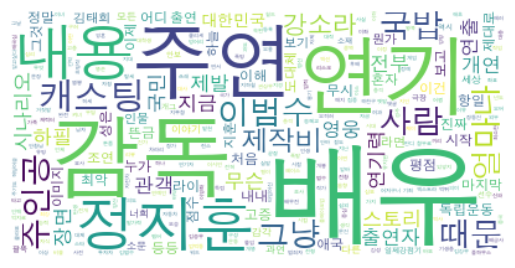

In [855]:
wc_noun = WordCloud(background_color='white', max_words=2000, font_path=r'/Library/Fonts/AppleGothic.ttf')
#빈도순으로 추출한 내용 넘겨주기
wc_noun = wc_noun.generate_from_frequencies(all_comments_count_noun)
plt.imshow(wc_noun, interpolation='bilinear')
plt.axis("off")
plt.show()

### 좀더 의미있는 알짜배기 정보만 시각화된 word cloud 를 그렸다 확실히 전체 리뷰보다 부정적인 단어가 많이 보인다

- 왜 이런 현상이 생겼을까 댓글을 전체적으로 봤더니 재미있게 본 사람들은 9, 10 점 댓글 + 장문으로 칭찬 일색이지만 0점 댓글의 대부분은 코멘트없이 평점만 0점을 준 데이터가 많다 + 재미 없다 생각한 영화는 굳이 리뷰를 안달고 재미 있는 영화는 리뷰를 다는 사람들의 착한 심리 + 재미없게 봤고 리뷰도 달지 않은 착한 사람들이 자신의 마음을 대변하는 부정적인 댓글에 공감을 누르는 사람 이러한 사람들로 인해 이런 현상이 일어났다고 생각한다

- 그냥 순수하게 데이터만 보기 쉽게 나열한다 해서 좋은 데이터 시각화 되는게 아니라는 것을 느꼈다